## Analyzing the monkeys' songs.
First, import a csv containing all of the lyrics

In [128]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

lyrics_df = pd.read_csv('data/lyrics.csv')

Cleaning the text, removing some words that will get in the way of the analysis.

In [129]:
import string, re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer


def remove_punc(lyrics):
    return "".join([c for c in lyrics if c not in string.punctuation])

def remove_stopwords(lyrics):
    return [w for w in lyrics if w not in stopwords.words('english')]

markers = ['[', ']','Verse','1','2','3','Chorus','Spoken Intro','Intro','Bridge','PreChorus', 'and','And','Outro']
def remove_markers(lyrics):
    return [w for w in lyrics if w not in markers]

lyrics = []
tokenizer = RegexpTokenizer(r'\w+')

lyrics_df['lyrics'] = lyrics_df['lyrics'].apply(lambda x: remove_punc(x))
lyrics_df['lyrics'] = lyrics_df['lyrics'].apply(lambda x: tokenizer.tokenize(x))
lyrics_df['lyrics'] = lyrics_df['lyrics'].apply(lambda x: remove_markers(x))
lyrics_df['lyrics'] = lyrics_df['lyrics'].apply(lambda x: remove_stopwords(x))
lyrics_df['lyrics'].head(20)

0     [Youve, never, met, But, still, greets, like, ...
1     [In, foreign, place, saving, grace, feeling, T...
2     [Arabellas, got, interstellargator, skin, boot...
3     [Get, way, mister, With, short, sharp, tips, N...
4     [Topless, models, Semaphore, Wave, flags, walk...
5     [Lately, Ive, seeing, things, belly, button, p...
6     [I, wanted, one, The, Strokes, Now, look, mess...
7     [Fools, parade, cavort, carry, waiting, eyes, ...
8     [You, got, HP, Lovecraft, Your, Edgar, Allan, ...
9     [Do, bad, thing, Take, wedding, ring, Oh, make...
10    [Jesus, day, spa, filling, information, form, ...
11    [I, got, eyes, youre, everything, I, see, I, w...
12    [Outside, cafe, cracker, factory, You, practic...
13    [Sank, calculations, snorted, stench, Of, arit...
14    [You, got, lights, afternoon, An, nights, draw...
15    [Here, come, old, flat, top, come, Groovin, sl...
16    [Instrumental, She, marrying, matador, weather...
17    [When, leave, us, patient, doors, That, ra

Using spacy, we'll see the most frequent words in the lyrics.

In [130]:
lyrics_df['lyrics'] = lyrics_df['lyrics'].apply(lambda x: ' '.join(x))

In [131]:
import spacy
from collections import Counter

def most_freq_words(df, number):
    sp = spacy.load('en_core_web_sm')
    complete_doc = sp(' '.join([i for i in df['lyrics']]))
    words = [token.text for token in complete_doc
             if not token.is_stop and not token.is_punct]
    word_freq = Counter(words)
    common_words = word_freq.most_common(number)
    print (common_words)

And we'll generate a wordcloud

In [132]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS

def word_cloud(df):
    v = TfidfVectorizer()
    x = v.fit_transform(df['lyrics'])
    text = df.lyrics.values
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'white',
        stopwords = STOPWORDS).generate(str(text))
    fig = plt.figure(
        figsize = (40, 30),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

Using all discography, we get the following:

[('nt', 433), ('s', 274), ('m', 177), ('know', 166), ('like', 144), ('ve', 136), ('got', 124), ('Oh', 122), ('want', 80), ('la', 78), ('said', 75), ('yeah', 74), ('love', 66), ('baby', 65), ('time', 64), ('d', 62), ('wanna', 62), ('Yeah', 59), ('eyes', 58), ('come', 50)]


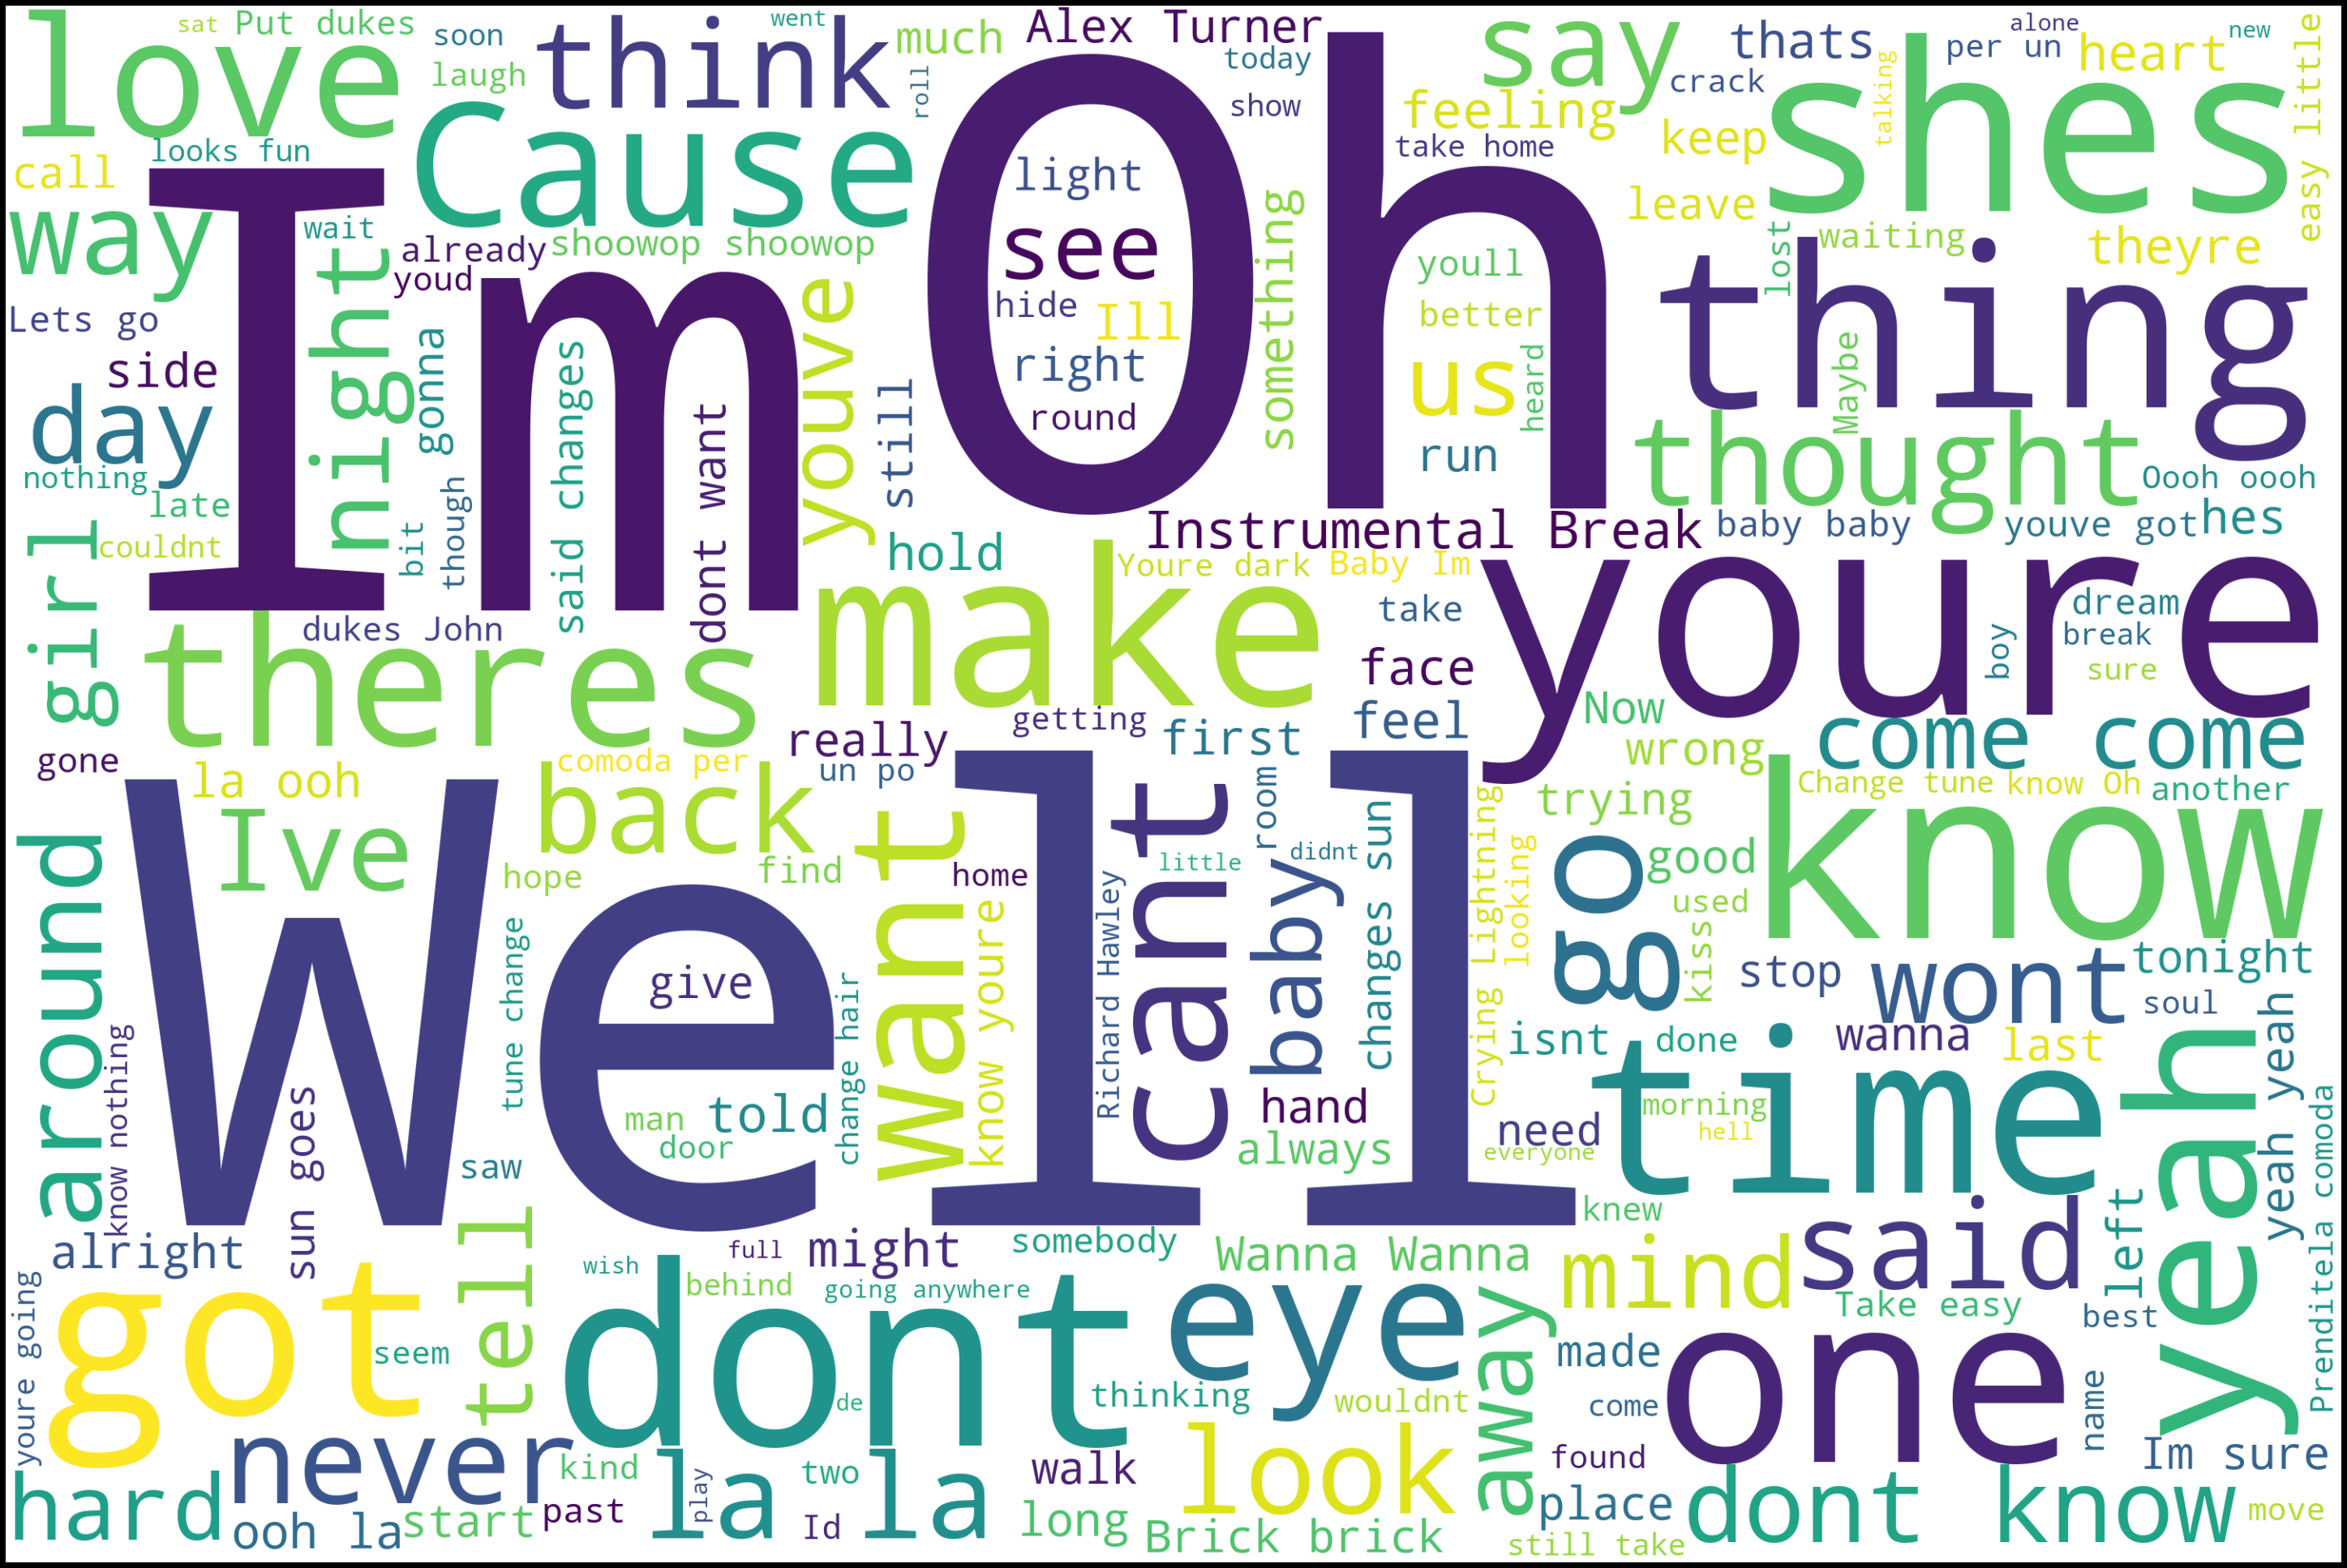

In [133]:
most_freq_words(lyrics_df, 20)
word_cloud(lyrics_df)

Now, only the 'Suck it and see' album.

[('s', 23), ('brick', 20), ('yeah', 18), ('ve', 16), ('Brick', 15), ('wanna', 13), ('nt', 12), ('got', 11), ('m', 11), ('thunderstorms', 11), ('like', 9), ('serenade', 8), ('treacle', 7), ('ohoh', 7), ('shoes', 7), ('love', 6), ('cause', 6), ('Shalalala', 6), ('shalalala', 6), ('aaaaah', 6)]


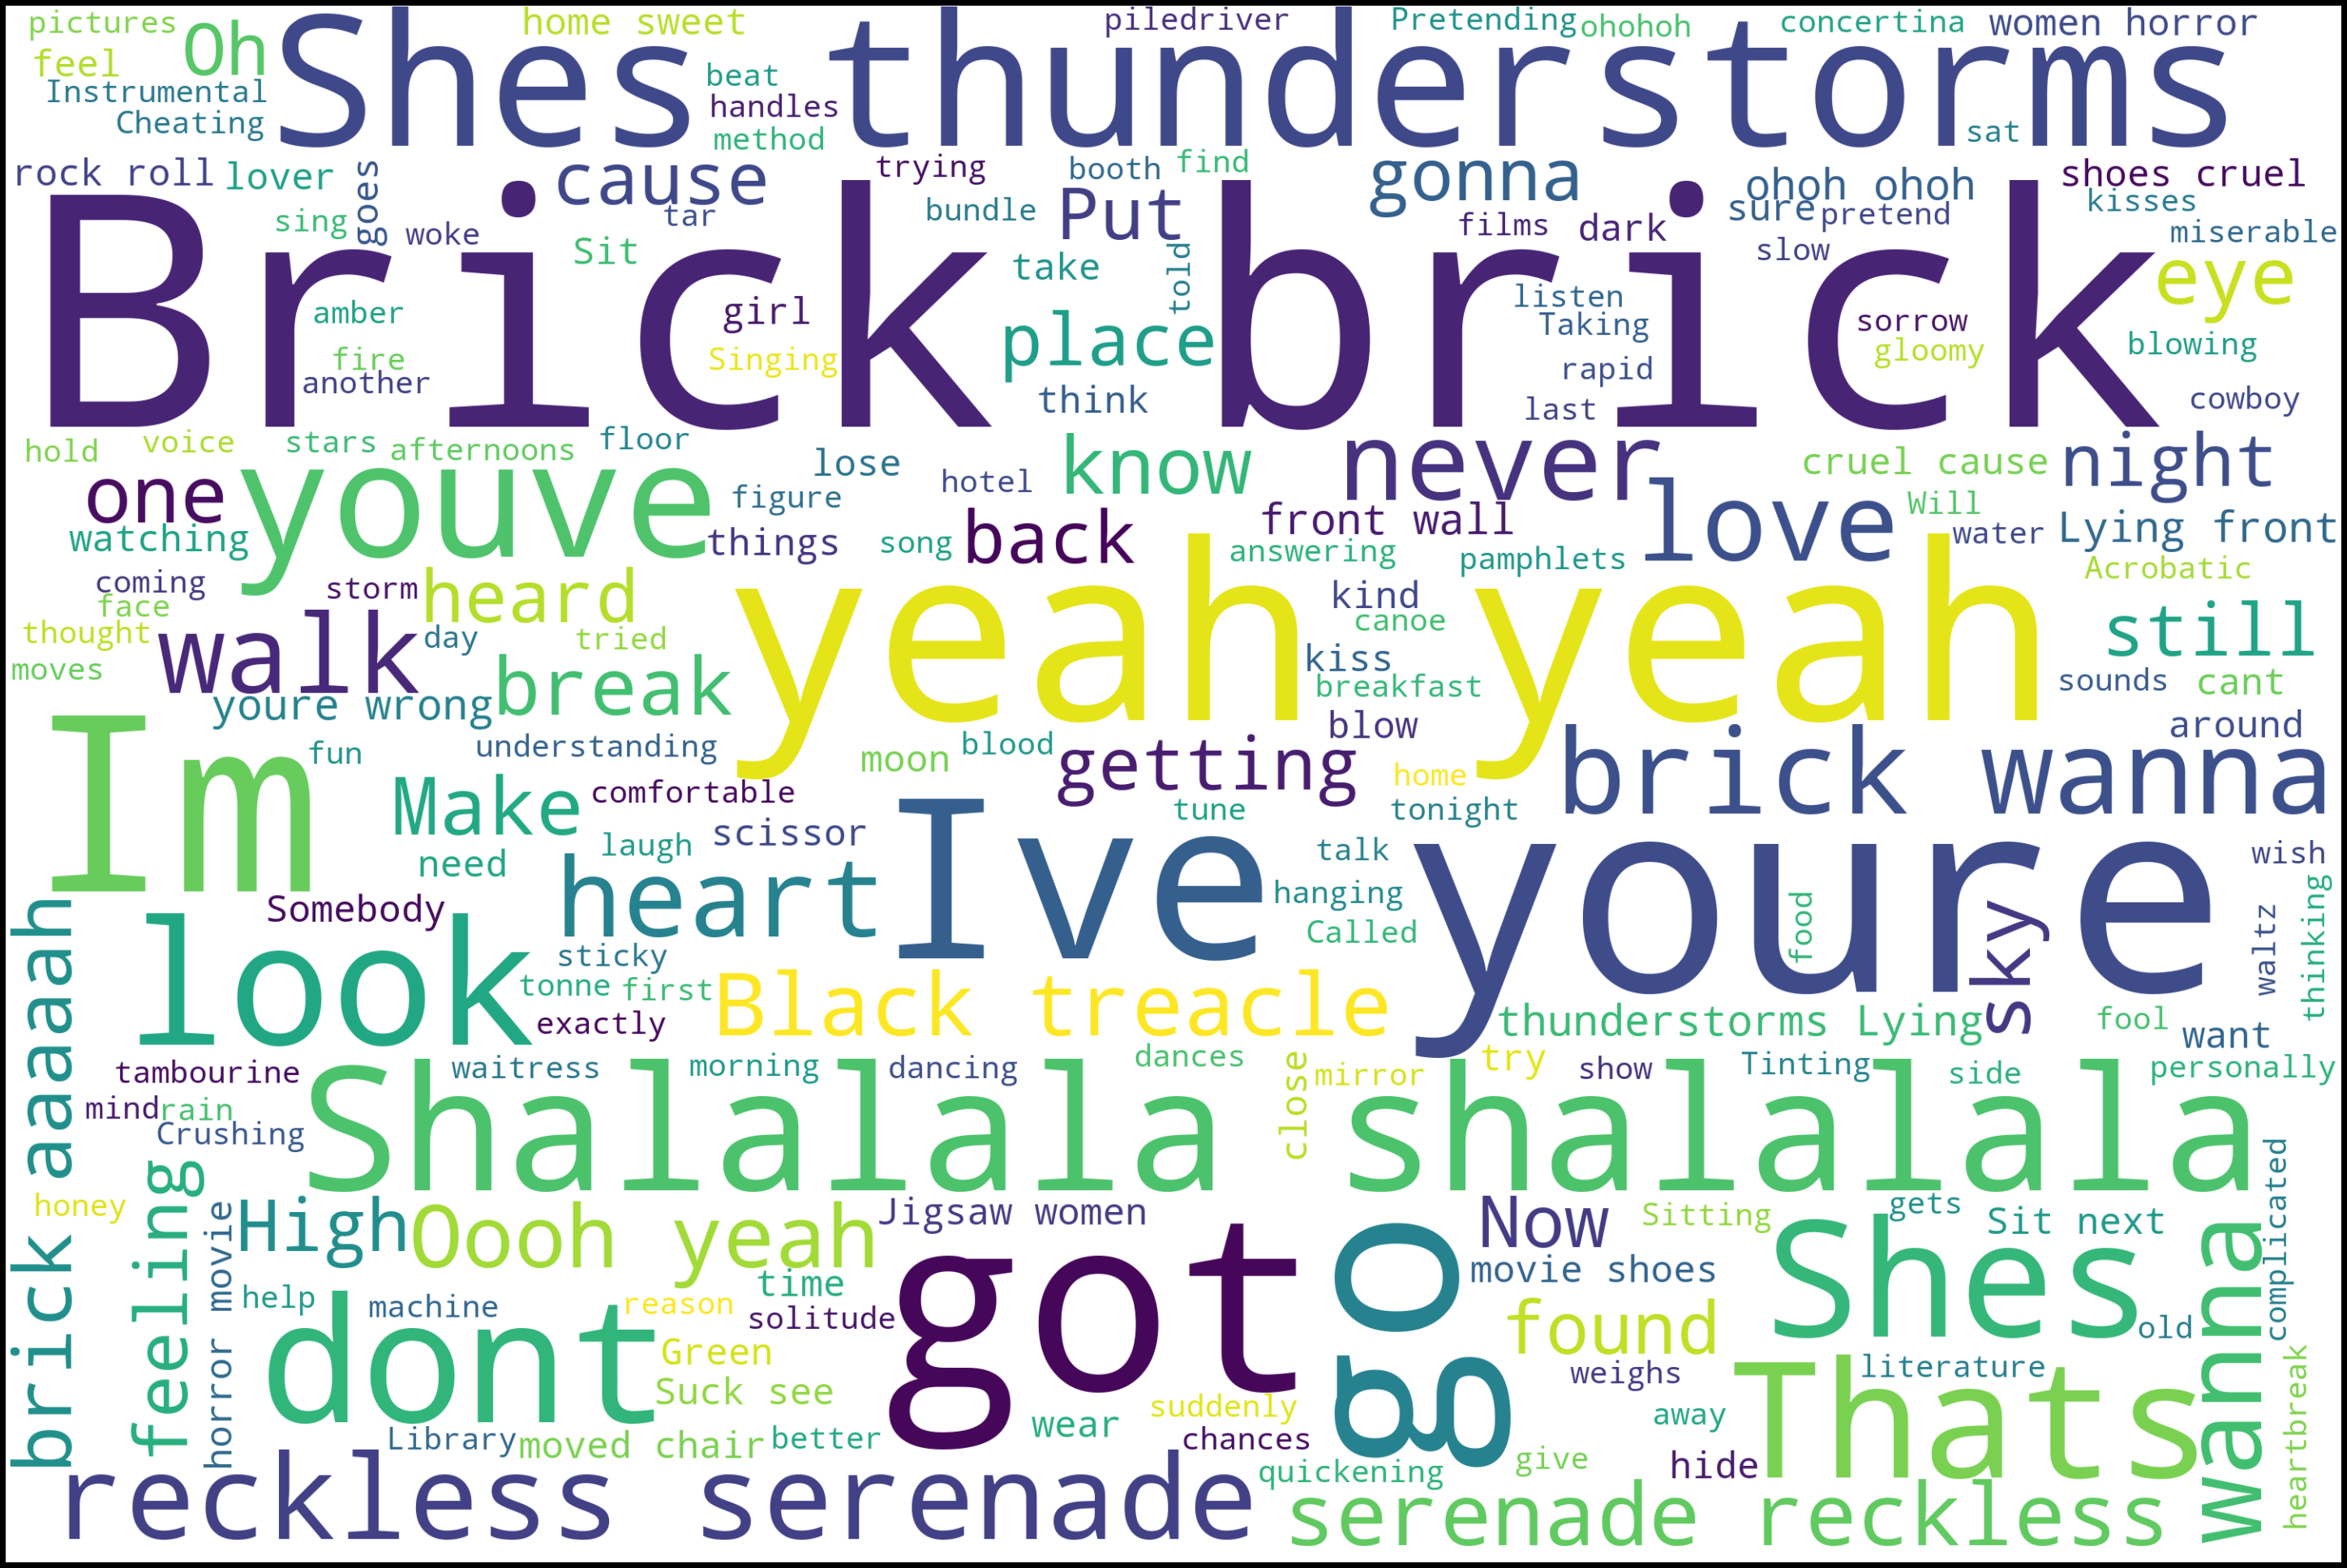

In [134]:
sias_df = lyrics_df[lyrics_df['album'] == 'Suck It and See']
most_freq_words(sias_df, 20)
word_cloud(sias_df)

Now, only the 'TBH&C' album.

[('like', 25), ('nt', 22), ('easy', 20), ('little', 18), ('ve', 17), ('looks', 16), ('fun', 14), ('m', 11), ('got', 11), ('time', 10), ('Come', 10), ('stay', 9), ('way', 8), ('thought', 8), ('stars', 8), ('popping', 7), ('new', 7), ('place', 6), ('love', 6), ('Cute', 6)]


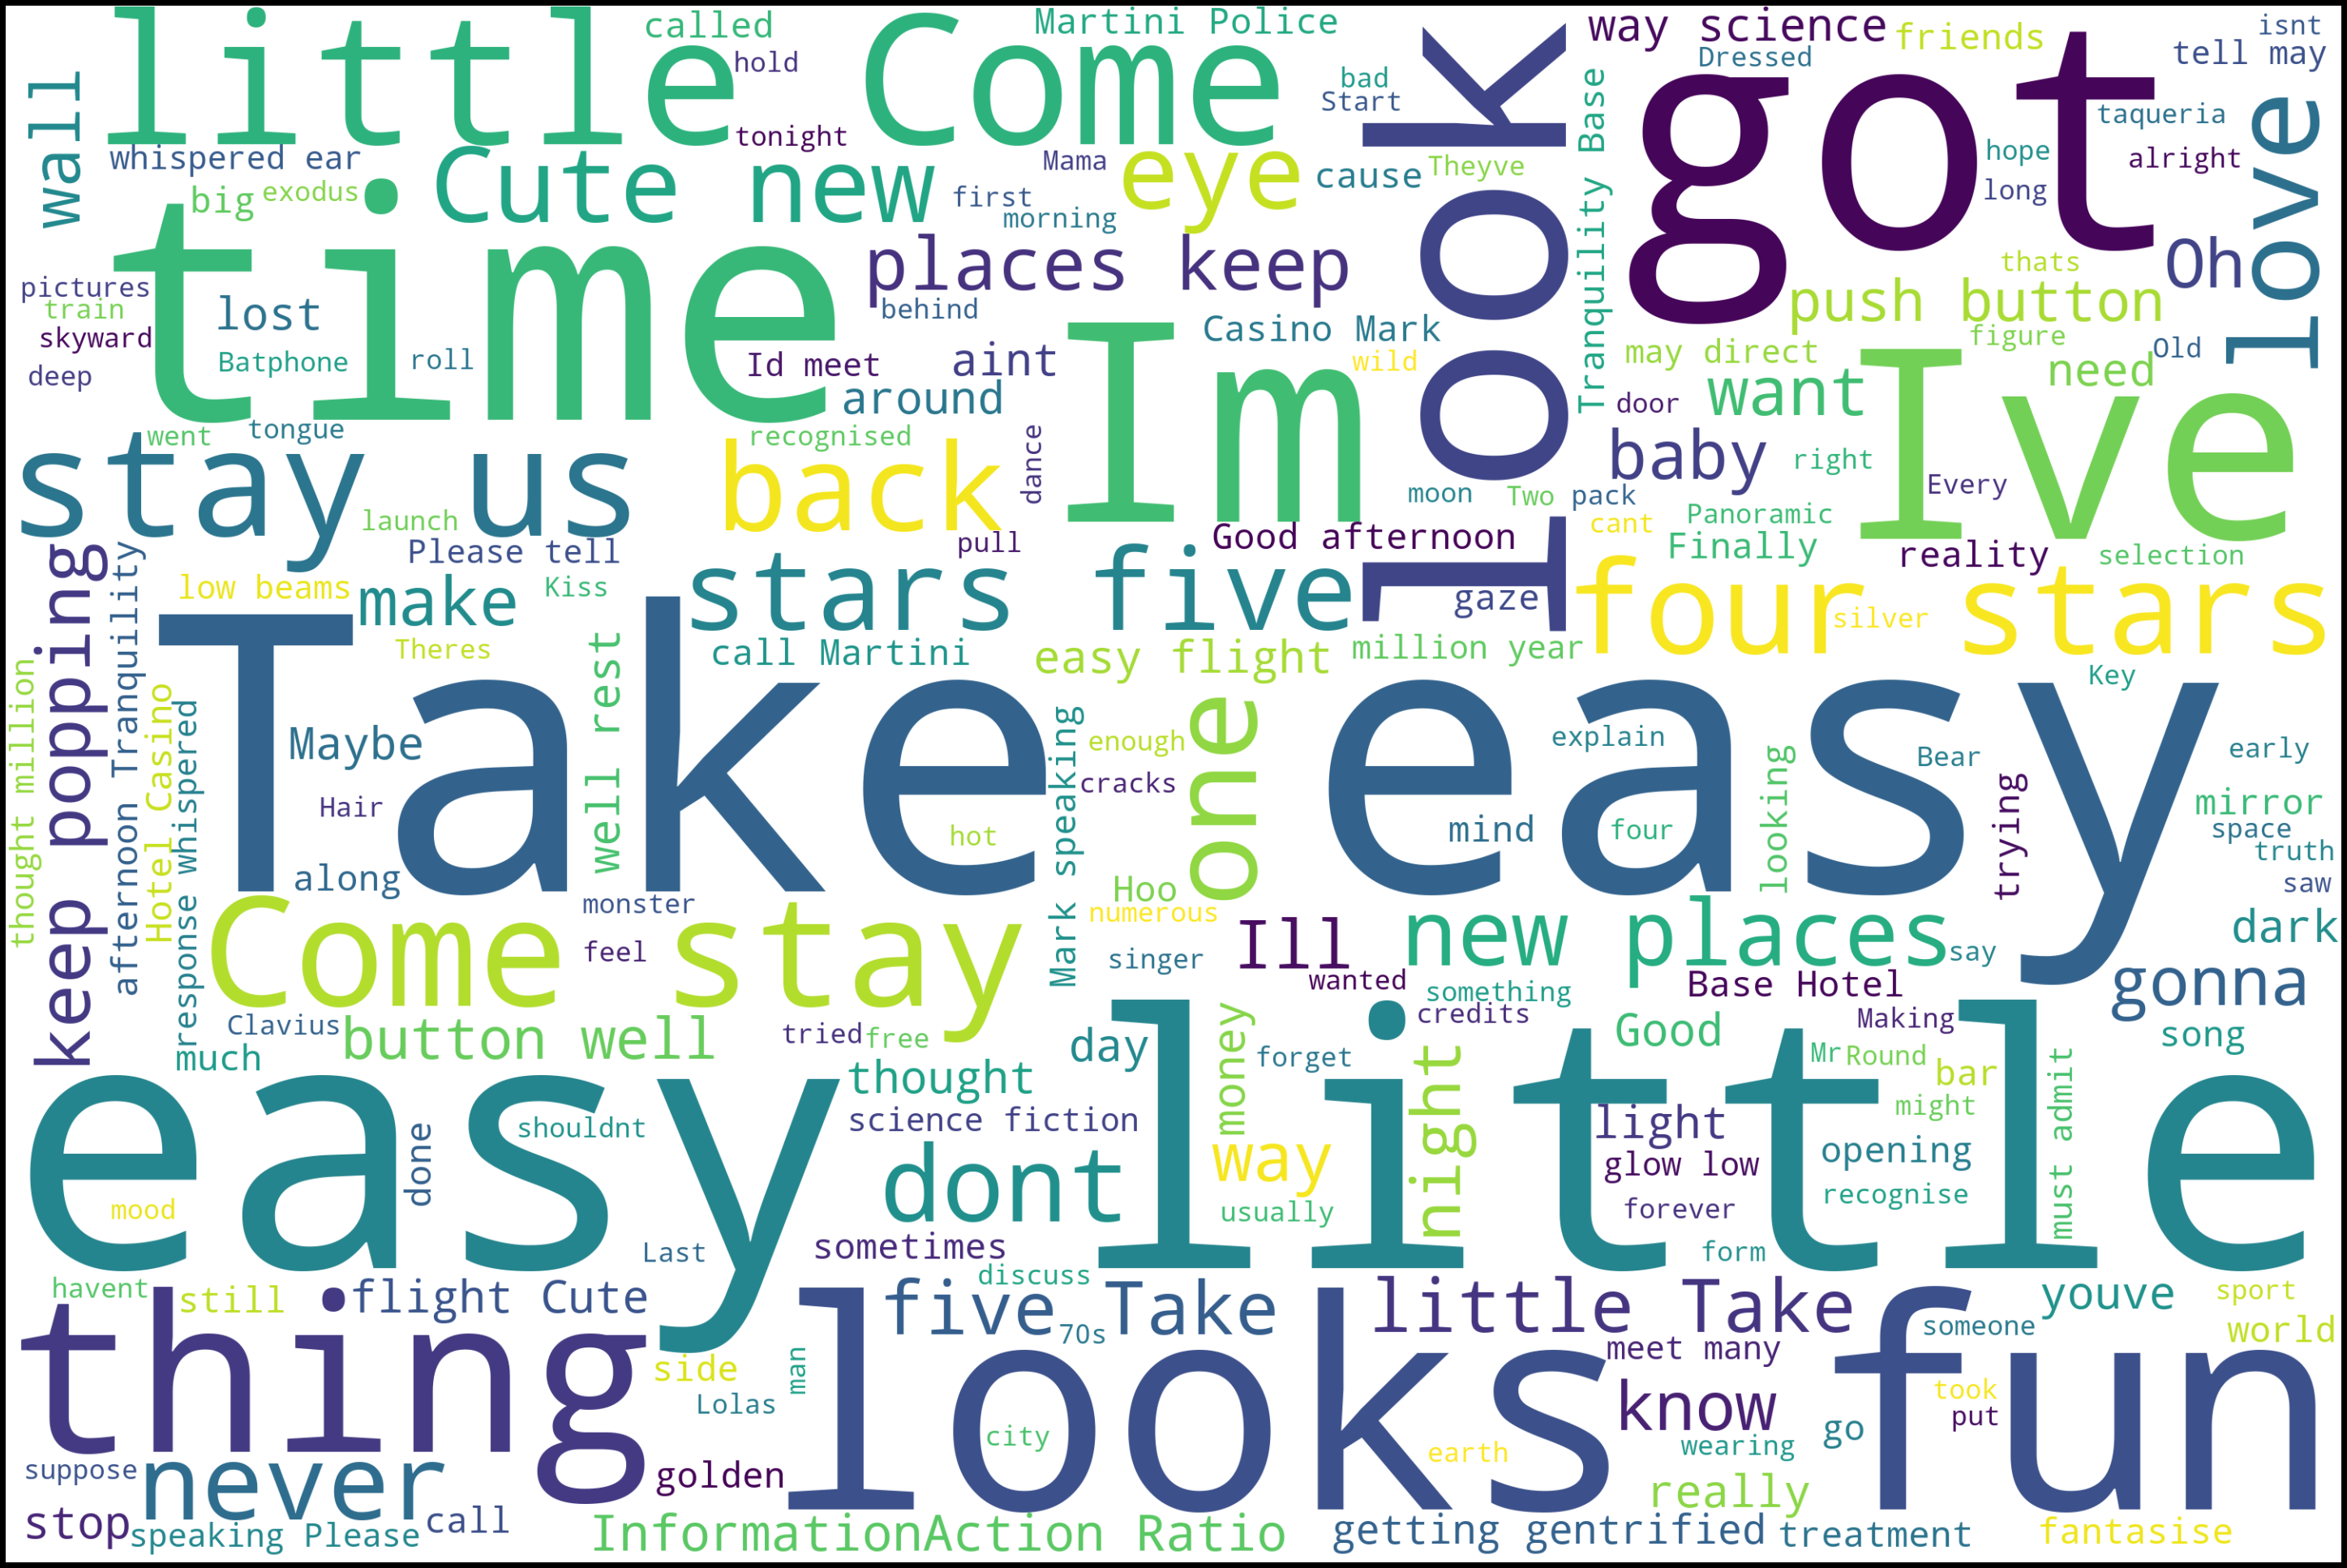

In [135]:
tranqulity_df = lyrics_df[lyrics_df['album'] == 'Tranquility Base Hotel & Casino']
most_freq_words(tranqulity_df, 20)
word_cloud(tranqulity_df)

What topics are more frequent in the lyrics? For what we'll use Latent Dirichlet Allocation

In [140]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

def print_top_words(model, feature_names, n_top_words):
    topics=[]
    for topic_idx, topic in enumerate(model.components_):
        topics.append([feature_names[i]
        for i in topic.argsort()[:-n_top_words - 1:-1]])    
    for t in topics:
        print(t)

def lda(tags):
    number_topics = 10
    no_top_words = 5
    no_features = 5000

    ct_vectorizer = CountVectorizer(max_features=no_features)
    tags_ct = ct_vectorizer.fit_transform(tags)

    lda = LatentDirichletAllocation(n_components=number_topics, n_jobs=-1)
    lda.fit(tags_ct)
    
    ct_features_names = ct_vectorizer.get_feature_names()
    print_top_words(lda, ct_features_names, no_top_words)
    

Running it on the whole discography, in the suck it and see and in the tbh&c album

In [141]:
lda(lyrics_df['lyrics'])

['la', 'know', 'the', 'im', 'youre']
['the', 'like', 'try', 'reckless', 'serenade']
['like', 'brick', 'got', 'but', 'she']
['come', 'wanna', 'tu', 'go', 'shes']
['youre', 'dont', 'oh', 'im', 'got']
['get', 'wont', 'youre', 'around', 'yeah']
['well', 'dont', 'tell', 'one', 'get']
['baby', 'mine', 'un', 'shes', 'are']
['youre', 'oh', 'know', 'dont', 'yeah']
['you', 'im', 'yeah', 'baby', 'idst']


In [142]:
lda(sias_df['lyrics'])

['got', 'ive', 'break', 'get', 'you']
['yeah', 'shalalala', 'oooh', 'home', 'like']
['shes', 'thunderstorms', 'wall', 'lying', 'front']
['got', 'ive', 'break', 'get', 'you']
['got', 'ive', 'break', 'get', 'you']
['brick', 'wanna', 'reckless', 'serenade', 'aaaaah']
['youre', 'ohoh', 'thats', 'wrong', 'love']
['high', 'im', 'green', 'got', 'youve']
['go', 'im', 'lover', 'youre', 'never']
['black', 'treacle', 'like', 'but', 'getting']


In [143]:
lda(tranqulity_df['lyrics'])

['got', 'im', 'good', 'like', 'back']
['like', 'looks', 'she', 'fun', 'got']
['easy', 'little', 'take', 'come', 'four']
['the', 'so', 'star', 'aint', 'treatment']
['ive', 'ill', 'im', 'get', 'need']
['fantasise', 'whispered', 'ear', 'response', 'sometimes']
['got', 'im', 'good', 'like', 'back']
['you', 'well', 'push', 'rest', 'button']
['the', 'way', 'but', 'fiction', 'science']
['mark', 'good', 'call', 'please', 'may']
